Cloning into 'Amthal'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 101 (delta 14), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (101/101), 2.84 MiB | 5.55 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/Amthal/Amthal/Amthal/Amthal/Amthal/Amthal/Amthal/Amthal/Amthal/Amthal/Amthal/Amthal/Amthal
Data loaded successfully. Found 4078 instances.

Generating the VERTICAL bipartite network visualization...


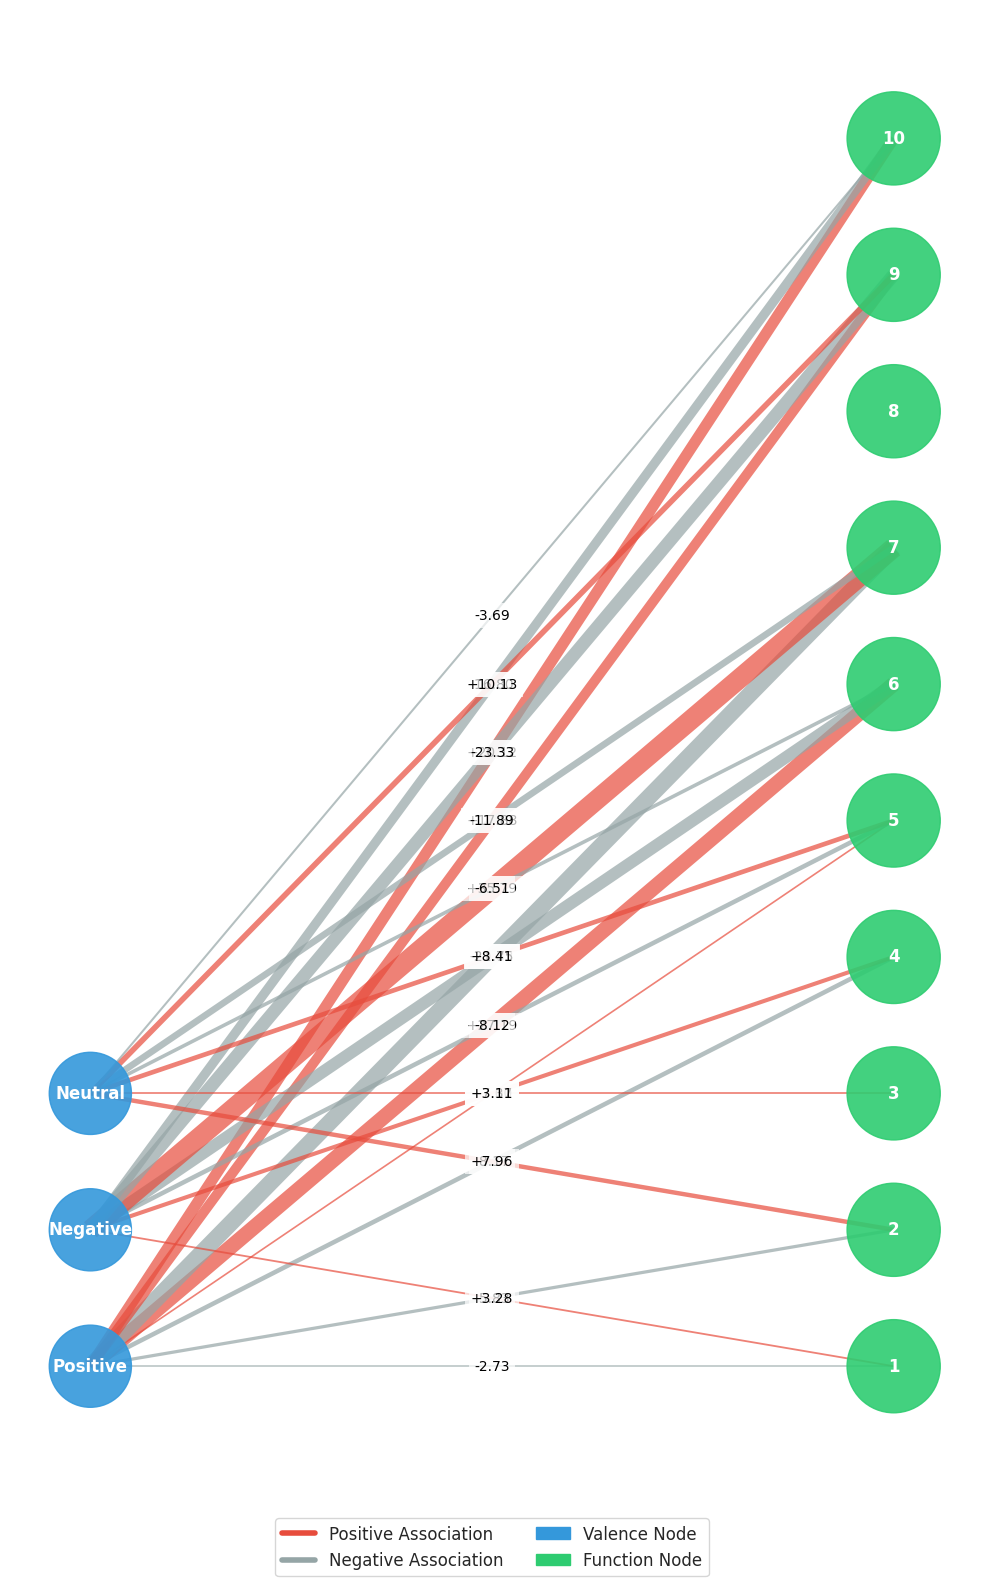

In [ ]:
#@title  **#  Bipartite network visualization of Valence–Function associations.**




# --- إعداد عام ---
!git clone https://github.com/NoorBayan/Amthal.git
%cd Amthal

from utility import *
from IPython.display import display, HTML, clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import combinations
import io
import statsmodels.api as sm
from matplotlib.lines import Line2D


import warnings

# تجاهل التحذيرات الخاصة بالخطوط
warnings.filterwarnings("ignore", message=".*font_manager.*")

# تعيين خط متوفر في كل بيئات matplotlib
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["font.serif"] = ["DejaVu Serif"]

# --- [الخطوة 1: تحميل وتجهيز البيانات] ---
INSTANCES_FILE_PATH = '/content/Amthal/data/processed/instances.csv'
try:
    df = pd.read_csv(INSTANCES_FILE_PATH, sep='\t', encoding='utf-16')
    df['Dominant_Concept']=[Dominant_Concept_dic[i]['en'] for i in df.Dominant_Concept]
    df['Valence']=[Valence_dic[i]['ar'] for i in df.Valence]
    df['Revelation_Phase']=[Revelation_Phase_dic[i]['ar'] for i in df.Revelation_Phase]
    df['Abstraction_Level']=[Abstraction_Level_dic[i]['ar'] for i in df.Abstraction_Level]
    print(f"Data loaded successfully. Found {len(df)} instances.\n")
except FileNotFoundError:
    print(f"⚠️ ERROR: File not found at '{INSTANCES_FILE_PATH}'. Please check the path and try again.")
    exit()





# --- 1 & 2. تحميل البيانات وحساب البقايا المعيارية (لا تغيير هنا) ---
contingency_table = pd.crosstab(df['Rhetorical_Function'], df['Valence'])
table = sm.stats.Table(contingency_table)
std_residuals_df = table.standardized_resids
# (كود الترجمة يبقى كما هو)
valence_cols_map = {'إيجابي': 'Positive', 'سلبي': 'Negative', 'محايد': 'Neutral'}
std_residuals_df.rename(columns=valence_cols_map, inplace=True)
function_index_map = {
    'امتنان': 'Gratitude', 'تشريع': 'Legislation', 'تعظيم': 'Glorification',
    'تقريب': 'Approximation', 'تمجيد': 'Exaltation', 'حجاج': 'Argumentation',
    'سرد': 'Narration', 'وصف': 'Description', 'وعد': 'Promise', 'وعيد': 'Warning'
}
std_residuals_df.rename(index=function_index_map, inplace=True)


# --- 3. بناء الشبكة ثنائية الأطراف (لا تغيير هنا) ---
B = nx.Graph()
valence_nodes = std_residuals_df.columns.tolist()
function_nodes = std_residuals_df.index.tolist()
B.add_nodes_from(valence_nodes, bipartite=0)
B.add_nodes_from(function_nodes, bipartite=1)
edge_list = []
for func_node in function_nodes:
    for val_node in valence_nodes:
        residual_value = std_residuals_df.loc[func_node, val_node]
        if abs(residual_value) > 1.96:
            edge_list.append((val_node, func_node, {'weight': residual_value}))
B.add_edges_from(edge_list)


# --- 4. إعداد الرسم البياني الاحترافي (مع تعديلات للتخطيط العمودي) ---
print("Generating the VERTICAL bipartite network visualization...")
sns.set_theme(style="white")
# >> التغيير 1: تعديل حجم الشكل ليكون عموديًا <<
fig, ax = plt.subplots(figsize=(10, 16))

# >> التغيير 2: عكس المحاور في تحديد مواقع العقد <<
pos = dict()
# الطبقة اليسرى (Valence)
pos.update( (n, (0, i)) for i, n in enumerate(valence_nodes) )
# الطبقة اليمنى (Rhetorical Function)
pos.update( (n, (1, i)) for i, n in enumerate(function_nodes) )


# إعداد خصائص الرسم (لا تغيير هنا)
node_sizes = [3500 if node in valence_nodes else 4500 for node in B.nodes()] # زيادة حجم عقد الوظائف
node_colors = ['#3498db' if node in valence_nodes else '#2ecc71' for node in B.nodes()]
edge_weights = nx.get_edge_attributes(B, 'weight')
edge_colors = ['#e74c3c' if weight > 0 else '#95a5a6' for weight in edge_weights.values()]
edge_widths = [abs(weight) / 2.5 for weight in edge_weights.values()] # تقليل السُمك قليلاً

# رسم الشبكة
nx.draw_networkx_nodes(B, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9, ax=ax)
nx.draw_networkx_labels(B, pos, font_size=12, font_weight='bold', font_color='white', ax=ax)
nx.draw_networkx_edges(B, pos, width=edge_widths, edge_color=edge_colors, alpha=0.7, ax=ax)

# >> التغيير 3: تحسين رسم تسميات الروابط للتخطيط العمودي <<
# سنقوم بتدوير التسميات قليلاً لتجنب التداخل
edge_labels = {k: f'{v:+.2f}' for k, v in edge_weights.items()}
nx.draw_networkx_edge_labels(
    B, pos,
    edge_labels=edge_labels,
    font_color='black',
    font_size=10,
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
    rotate=False # إبقاء التسميات أفقية
)

# --- 5. إضافة التحسينات البصرية ---
#ax.set_title('Bipartite Network of Valence–Function Associations', fontsize=20, fontweight='bold', pad=20)
legend_elements = [
    Line2D([0], [0], color='#e74c3c', lw=4, label='Positive Association'),
    Line2D([0], [0], color='#95a5a6', lw=4, label='Negative Association'),
    plt.Rectangle((0,0),1,1, color='#3498db', label='Valence Node'),
    plt.Rectangle((0,0),1,1, color='#2ecc71', label='Function Node')
]
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=2, fontsize=12) # وضع الأسطورة في الأسفل

ax.axis('off')
# ضبط حدود الرسم يدويًا لضمان عدم اقتصاص أي شيء
plt.xlim(-0.1, 1.1)

# --- 6. الحفظ والعرض ---
plt.tight_layout()
plt.savefig('FBipartite_Network_Vertical.png', dpi=300, bbox_inches='tight')
plt.show()